In [507]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline

### Calibrating a Camera

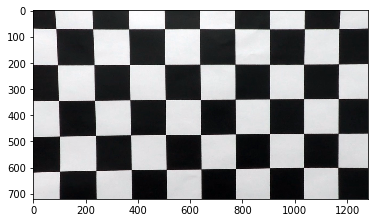

In [508]:
dir_path="C:/Users/Abhishek/Desktop/CarND-Advanced-Lane-Lines-master/camera_cal"
files=os.listdir(dir_path)
# print(files)
# img=cv2.imread(dir_path+"/"+files[0])
# plt.imshow(img)
objpoints=[]
imgpoints=[]

objp=np.zeros((6*9,3),np.float32)
# print(objp.shape)
a=np.mgrid[0:9,0:6].T.reshape(-1,2)
# print(a.shape)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
files_with_corners=0
for i in range(len(files)):
    img=cv2.imread(dir_path+"/"+files[i])
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners=cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        files_with_corners=files_with_corners+1
#         print("corners found")
        imgpoints.append(corners)
        objpoints.append(objp)
    img=cv2.drawChessboardCorners(img,(9,6),corners,ret)
    plt.imshow(img)
    
# print(files_with_corners)
# print(len(objpoints))
# print(len(imgpoints))
# test_img=cv2.imread(dir_path+"/"+files[0])
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
undist = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.imshow(undist)

#### Pilpeline

In [529]:
def pipeline(img):
# img=mpimg.imread("C:\\Users\\Abhishek\\Desktop\\CarND-Advanced-Lane-Lines-master\\test_images\\test6.jpg")
    undist = cv2.undistort(img, mtx, dist, None, mtx)
#     gray=cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
#     plt.imshow(undist)
    src=np.float32([[490,480],[40,720],[1250,720],[810,480]])
    dst=np.float32([[0,0],[50,720],[1240,720],[1280,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
#     plt.imshow(warped)
    gray=cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx > 40) & (scaled_sobelx < 255)] = 1
    plt.imshow(scaled_sobelx,cmap='gray')

    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely > 50) & (scaled_sobely < 100)] = 1
    # plt.imshow(sybinary,cmap='gray')

    abs_sobelxy = np.sqrt(abs_sobelx**2+abs_sobely**2)
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxybinary = np.zeros_like(scaled_sobelxy)
    sxybinary[(scaled_sobelxy > 30) & (scaled_sobelxy < 100)] = 1
    # plt.imshow(sxybinary,cmap='gray')

    hls=cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    s_ch_binary = np.zeros_like(s_channel)
    s_ch_binary[(s_channel > 180) & (s_channel < 255)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_ch_binary == 1) | (sxbinary == 1)] = 1
    # plt.imshow(s_ch_binary,cmap='gray')
    # plt.imshow(l_channel,cmap='gray')
    l_ch_binary = np.zeros_like(l_channel)
    l_ch_binary[(l_channel > 100) & (l_channel <= 255)] = 1
#     plt.imshow(combined_binary,cmap='gray')

    a1 = np.array( [[[100,0],[100,720],[1280,720],[1280,0]]], dtype=np.int32 )
    # a2 = np.array( [[[400,720],[590,455],[680,455],[1000,720]]], dtype=np.int32 )
    im = np.zeros([img.shape[0],img.shape[1]],dtype=np.uint8)
    cv2.fillPoly( im, a1, 255 )
    # cv2.fillPoly( im, a2, 0 )
    plt.imshow(im,cmap='gray')

    binary_warped=np.zeros_like(combined_binary)
    binary_warped[(combined_binary==1) & (im==255)]=1
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # plt.imshow(out_img,cmap='gray')

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        '''
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        '''
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # plt.imshow(out_img)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    window_img = np.zeros_like(img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    plt.imshow(window_img)
    # cv2.fillPoly(window_img, np.int_([right_line_window1]), (0,255, 0))
    # result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
    # plt.imshow(window_img)
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # result = cv2.addWeighted(window_img_1, 1, window_img, 0.2, 0)
    # plt.imshow(result)
    warped_inv = cv2.warpPerspective(window_img, Minv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, warped_inv, 0.5, 0)
    plt.imshow(warped_inv)
    return result

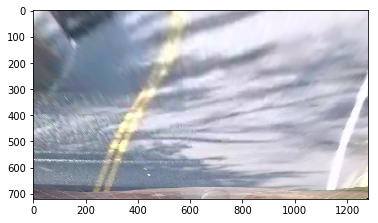

In [514]:
img=mpimg.imread("C:\\Users\\Abhishek\\Desktop\\CarND-Advanced-Lane-Lines-master\\test_images\\test7.png")
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray=cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
plt.imshow(undist)
src=np.float32([[490,480],[40,720],[1250,720],[810,480]])
dst=np.float32([[0,0],[50,720],[1240,720],[1280,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)
gray=cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

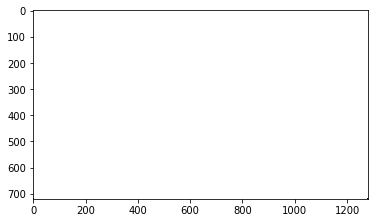

In [528]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=3)
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobelx > 30) & (scaled_sobelx < 255)] = 1
plt.imshow(scaled_sobelx,cmap='gray')

abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
sybinary = np.zeros_like(scaled_sobely)
sybinary[(scaled_sobely > 50) & (scaled_sobely < 100)] = 1
# plt.imshow(sybinary,cmap='gray')

abs_sobelxy = np.sqrt(abs_sobelx**2+abs_sobely**2)
scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
sxybinary = np.zeros_like(scaled_sobelxy)
sxybinary[(scaled_sobelxy > 30) & (scaled_sobelxy < 100)] = 1
# plt.imshow(sxybinary,cmap='gray')

hls=cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
s_channel=hls[:,:,2]
l_channel=hls[:,:,1]
s_ch_binary = np.zeros_like(s_channel)
s_ch_binary[(s_channel > 180) & (s_channel < 255)] = 1

combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_ch_binary == 1) | (sxbinary == 1)] = 1
# plt.imshow(s_ch_binary,cmap='gray')
plt.imshow(l_channel,cmap='gray')
l_ch_binary = np.zeros_like(l_channel)
l_ch_binary[(l_channel > 0) & (l_channel <= 205)] = 1
plt.imshow(l_ch_binary,cmap='gray')
# plt.imshow(combined_binary,cmap='gray')

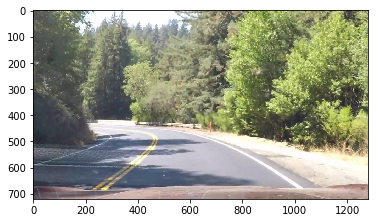

In [530]:
import os
path="C:/Users/Abhishek/Desktop/CarND-Advanced-Lane-Lines-master"
files=os.listdir(path+"/test_images")
for file in files:
#     print(file)
    img=mpimg.imread("./test_images/"+file)
    a=pipeline(img)
    plt.imshow(a)
    plt.savefig(path+"/test_images/"+file.split(".")[0]+"_aug.jpg")

#### Mask Region

(720, 1280, 3)


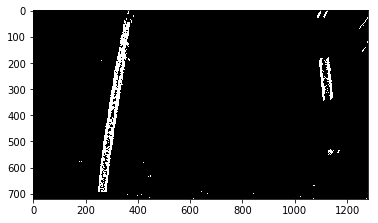

In [489]:
print(img.shape)
a1 = np.array( [[[100,0],[100,720],[1280,720],[1280,0]]], dtype=np.int32 )
# a2 = np.array( [[[400,720],[590,455],[680,455],[1000,720]]], dtype=np.int32 )
im = np.zeros([img.shape[0],img.shape[1]],dtype=np.uint8)
cv2.fillPoly( im, a1, 255 )
# cv2.fillPoly( im, a2, 0 )
plt.imshow(im,cmap='gray')

binary_warped=np.zeros_like(combined_binary)
binary_warped[(combined_binary==1) & (im==255)]=1
plt.imshow(binary_warped,cmap='gray')

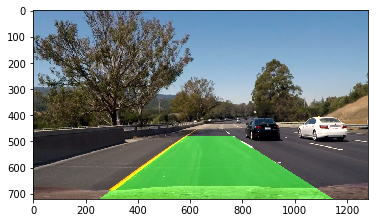

In [492]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# plt.imshow(out_img,cmap='gray')

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    '''
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    '''
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

window_img = np.zeros_like(img)
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, right_line_window2))
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
plt.imshow(window_img)
# cv2.fillPoly(window_img, np.int_([right_line_window1]), (0,255, 0))
# result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
# plt.imshow(window_img)
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# result = cv2.addWeighted(window_img_1, 1, window_img, 0.2, 0)
# plt.imshow(result)
warped_inv = cv2.warpPerspective(window_img, Minv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, warped_inv, 0.5, 0)
plt.imshow(warped_inv)
plt.imshow(result)

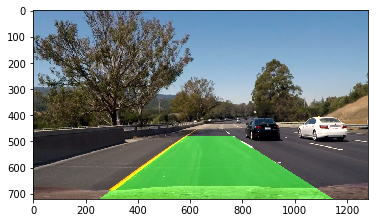

In [491]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

window_img = np.zeros_like(img)
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, right_line_window2))
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
plt.imshow(window_img)
# cv2.fillPoly(window_img, np.int_([right_line_window1]), (0,255, 0))
# result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
# plt.imshow(window_img)
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# result = cv2.addWeighted(window_img_1, 1, window_img, 0.2, 0)
# plt.imshow(result)
warped_inv = cv2.warpPerspective(window_img, Minv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, warped_inv, 0.5, 0)
plt.imshow(warped_inv)
plt.imshow(result)

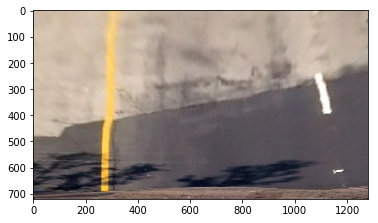

In [388]:
img_1=mpimg.imread("C:\\Users\\Abhishek\\Desktop\\CarND-Advanced-Lane-Lines-master\\test_images\\test6.jpg")
src=np.float32([[490,480],[40,720],[1250,720],[810,480]])
dst=np.float32([[0,0],[50,720],[1240,720],[1280,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

#### Perspective Transformation

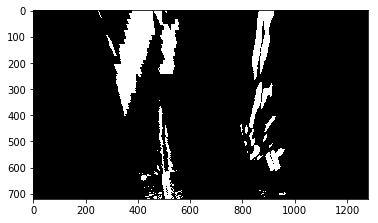

In [362]:
src=np.float32([[200,660],[1120,660],[740,458],[600,458]])
dst=np.float32([[200,720],[1100,720],[1100,0],[200,0]])
src=np.float32([[610,440],[200,670],[1100,670],[730,440]])
dst=np.float32([[440,0],[440,720],[960,720],[960,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size=(img.shape[1],img.shape[0])
# print(img_size.shape)
warped = cv2.warpPerspective(region_comb_img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')
img_size=(img.shape[1],img.shape[0])
w_inv=cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
# plt.imshow(w_inv,cmap='gray')